# Lecture 8
The image used in these examples is available [here](https://drive.google.com/file/d/1OvVYhq--hyiriUSxgxUyRKtPL73xM0Qk/view?usp=sharing).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, color, img_as_float

In [2]:
plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[15,8]

In [3]:
I = io.imread('watch_color.png')

In [5]:
I.shape

(768, 1024, 3)

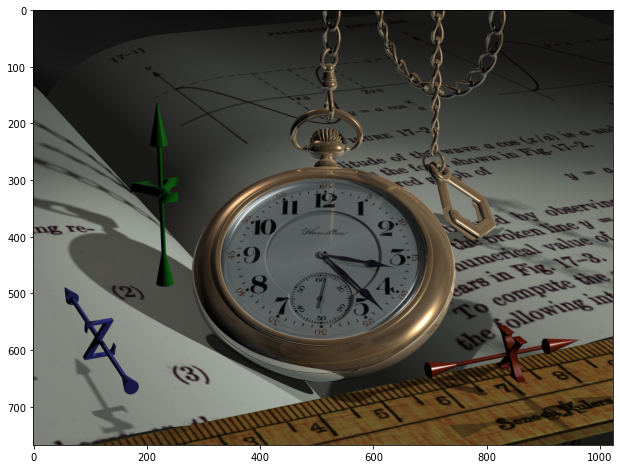

In [4]:
plt.imshow(I)

### RGB model

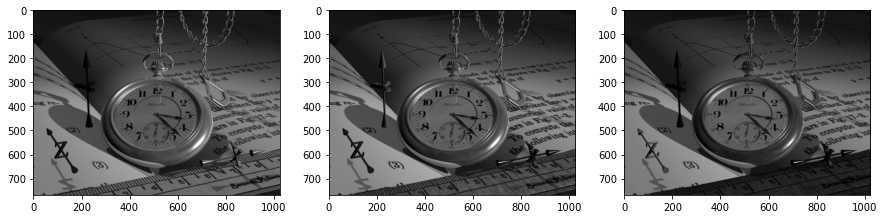

In [6]:
plt.subplot(131)
plt.imshow(I[:,:,0],'gray')
plt.subplot(132)
plt.imshow(I[:,:,1],'gray')
plt.subplot(133)
plt.imshow(I[:,:,2],'gray')

In [7]:
K = np.copy(I)
K[:,:,2] = (1.5*K[:,:,2]).clip(0,255)

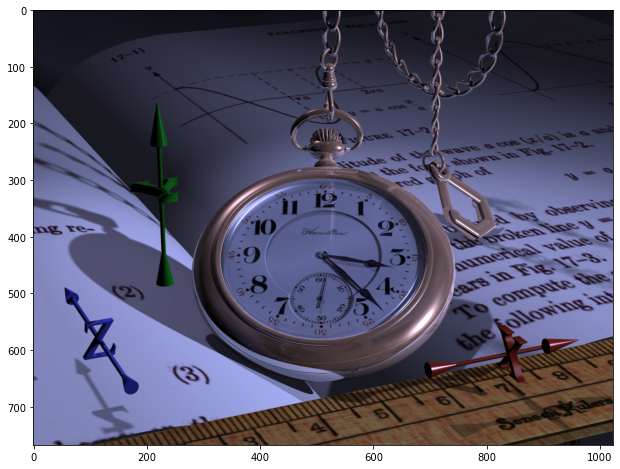

In [8]:
plt.imshow(K)

### HSV model

In [9]:
hsv = color.rgb2hsv(I)

In [10]:
hsv.shape

(768, 1024, 3)

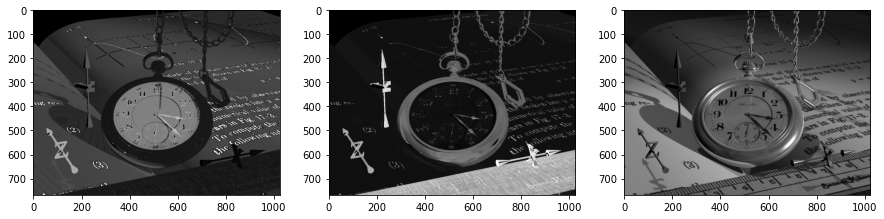

In [11]:
plt.subplot(131)
plt.imshow(hsv[:,:,0],'gray')
plt.subplot(132)
plt.imshow(hsv[:,:,1],'gray')
plt.subplot(133)
plt.imshow(hsv[:,:,2],'gray')

In [12]:
hsv[:,:,1] = 1

In [13]:
rgb = color.hsv2rgb(hsv)

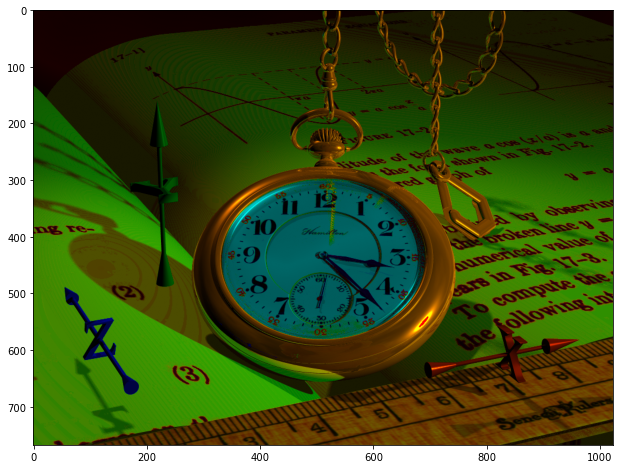

In [14]:
plt.imshow(rgb)

### Tone correction

In [15]:
hsv = color.rgb2hsv(I)
hsv[:,:,2] = hsv[:,:,2]**0.5
rgb = color.hsv2rgb(hsv)

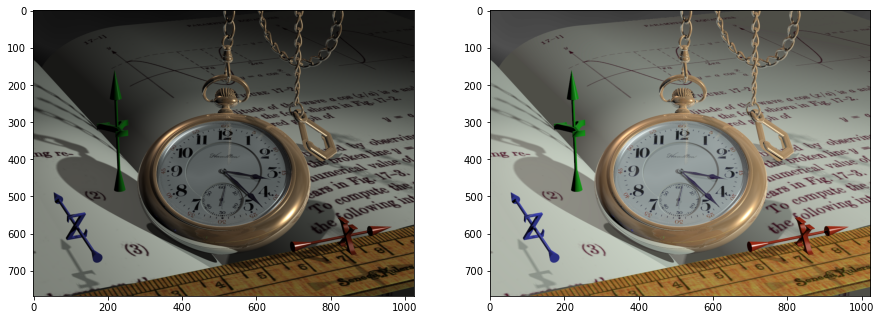

In [16]:
plt.subplot(121)
plt.imshow(I)
plt.subplot(122)
plt.imshow(rgb)

In [17]:
J = (img_as_float(I)**0.5)

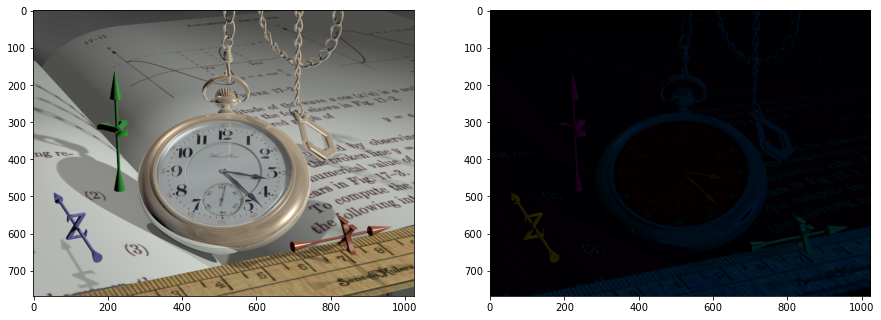

In [18]:
plt.subplot(121)
plt.imshow(J)
plt.subplot(122)
plt.imshow(abs(rgb-J))

### Histogram equalization

In [19]:
from skimage.exposure import equalize_hist

In [20]:
rgb = np.zeros_like(I).astype('float')

In [21]:
rgb[:,:,0] = equalize_hist(I[:,:,0])
rgb[:,:,1] = equalize_hist(I[:,:,1])
rgb[:,:,2] = equalize_hist(I[:,:,2])

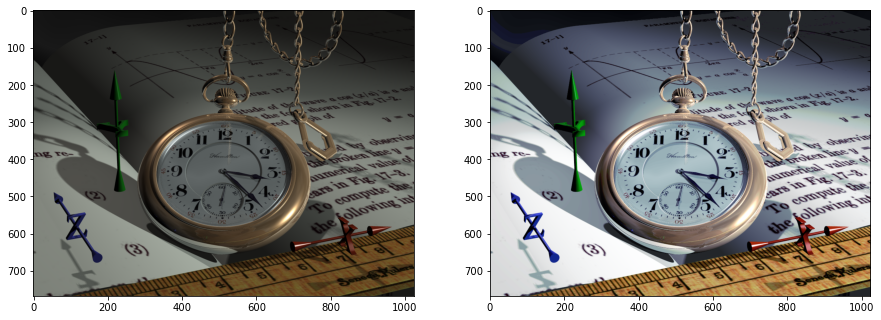

In [22]:
plt.subplot(121)
plt.imshow(I)
plt.subplot(122)
plt.imshow(rgb)

In [23]:
hsv = color.rgb2hsv(I)
hsv[:,:,2] = equalize_hist(hsv[:,:,2])
rgb = color.hsv2rgb(hsv)

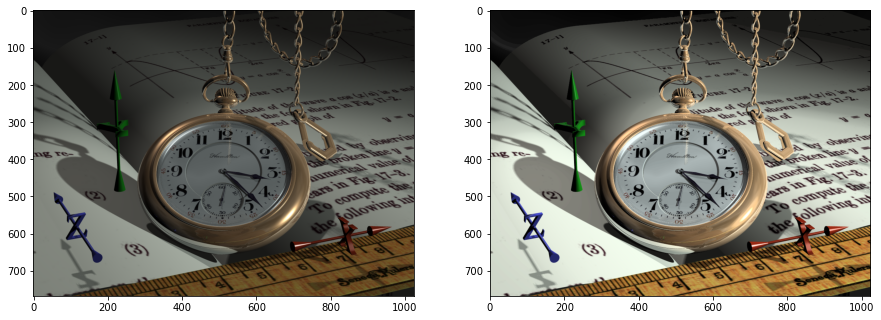

In [24]:
plt.subplot(121)
plt.imshow(I)
plt.subplot(122)
plt.imshow(rgb)

### Mean filtering

In [25]:
filt = np.ones((7,7,1))/49

In [26]:
from scipy.ndimage import convolve

In [27]:
F = convolve(rgb,filt)

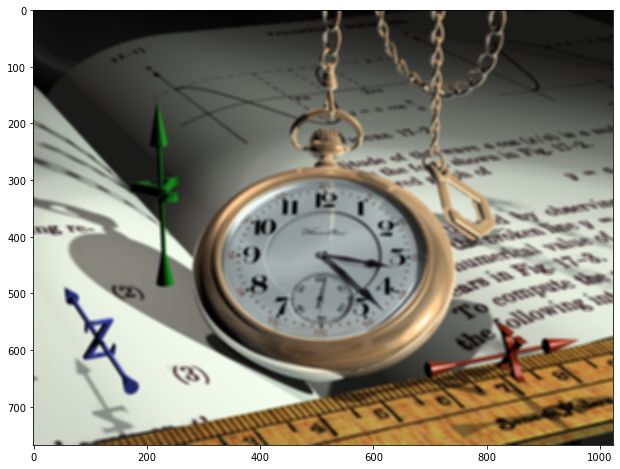

In [28]:
plt.imshow(F)

### Mean filtering over channels

In [29]:
filt3d = np.ones((7,7,3))/147

In [30]:
G = convolve(rgb,filt3d)

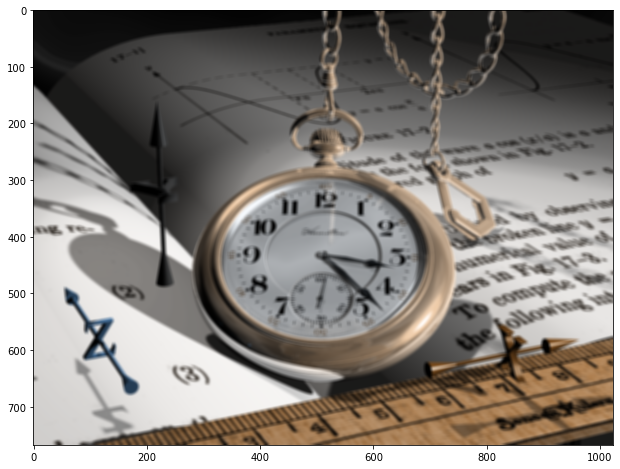

In [31]:
plt.imshow(G)

### Image pyramid

In [32]:
I = hsv[:,:,2]

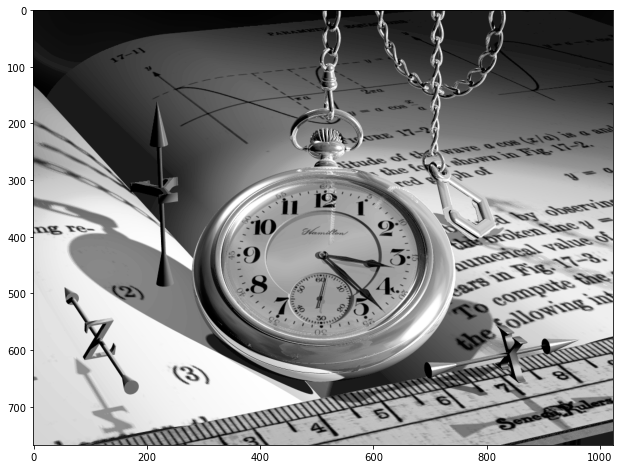

In [33]:
plt.imshow(I)

In [34]:
from skimage.filters import gaussian

In [35]:
def approximation(I):
    G = gaussian(I)
    return G[1::2,1::2]

In [36]:
def prediction(A):
    P = np.zeros(np.array(A.shape)*2,dtype=float)
    P[1::2,1::2] = 4*A
    return gaussian(P).clip(0,1)

In [37]:
A1 = approximation(I)

In [38]:
P = prediction(A1)

In [39]:
R = I - P

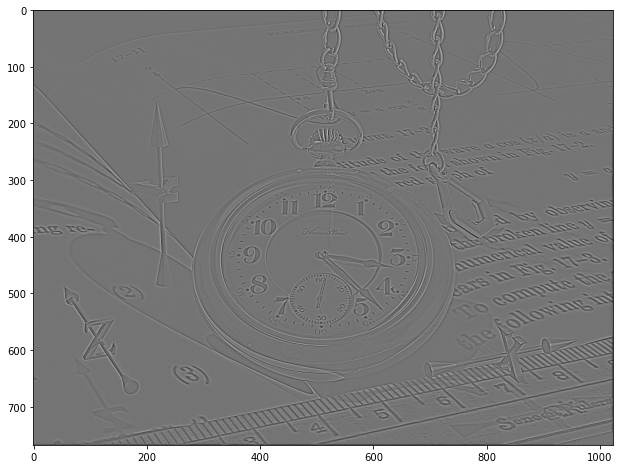

In [40]:
plt.imshow(R)

In [41]:
A2 = approximation(A1)
P1 = prediction(A2)
R1 = A1 - P1
A3 = approximation(A2)
P2 = prediction(A3)
R2 = A2 - P2

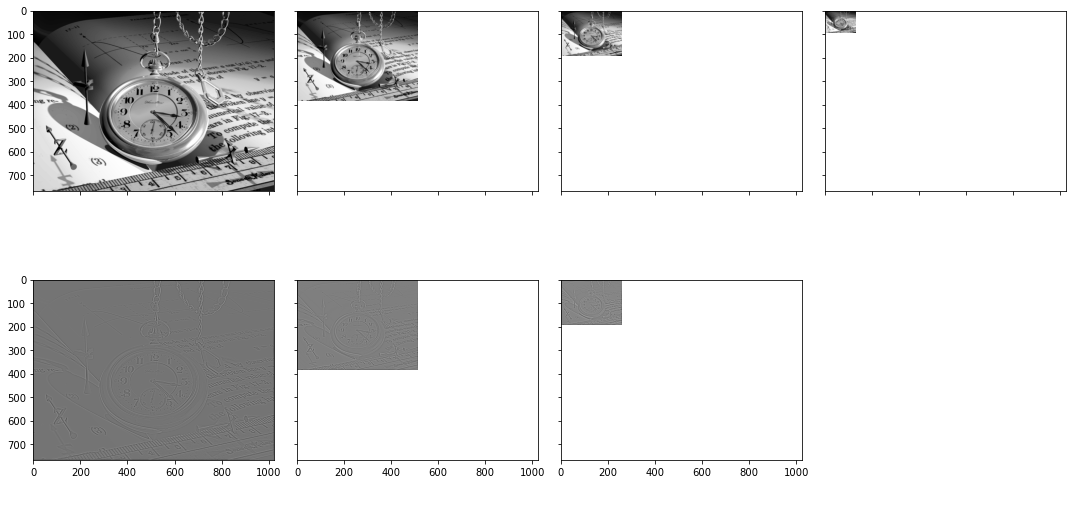

In [42]:
m, n = I.shape
f, ax = plt.subplots(2, 4, sharey=True, sharex=True)
ax[0,0].imshow(I)
ax[0,0].axis([0,n,m,0])
ax[0,1].imshow(A1)
ax[0,2].imshow(A2)
ax[0,3].imshow(A3)
ax[1,0].imshow(R)
ax[1,1].imshow(R1)
ax[1,2].imshow(R2)
ax[1,3].axis('off');
plt.tight_layout()

### 1D subband coding

In [43]:
from scipy.signal import daub,qmf,convolve

In [44]:
def decimate_1d(f,h,n):
    out = convolve(f,h)
    out = out[n-1::n]
    return out

In [45]:
def interpolate_1d(f,h,n):
    out = np.zeros(len(f)*n+n-1,dtype=float)
    out[n-1::n] = f
    out = convolve(out,h,'valid')
    return out

In [46]:
g0 = daub(4)
g1 = qmf(g0)
h0 = g0[::-1]
h1 = g1[::-1]

In [47]:
print(g0)

[ 0.23037781  0.71484657  0.63088077 -0.02798377 -0.18703481  0.03084138
  0.03288301 -0.0105974 ]


In [48]:
s = I[256,:]

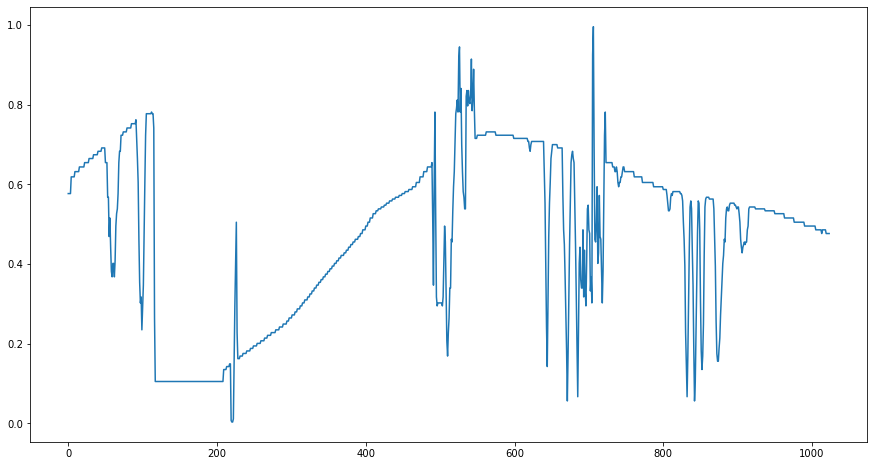

In [49]:
plt.plot(s)

In [50]:
lp = decimate_1d(s,h0,2)

In [51]:
hp = decimate_1d(s,h1,2)

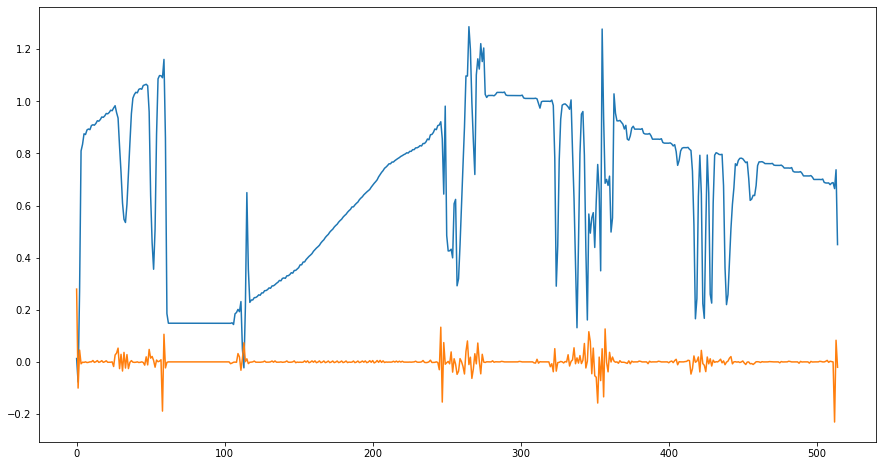

In [52]:
plt.plot(lp)
plt.plot(hp)

In [53]:
rlp = interpolate_1d(lp,g0,2)
rhp = interpolate_1d(hp,g1,2)

In [54]:
r = rlp + rhp

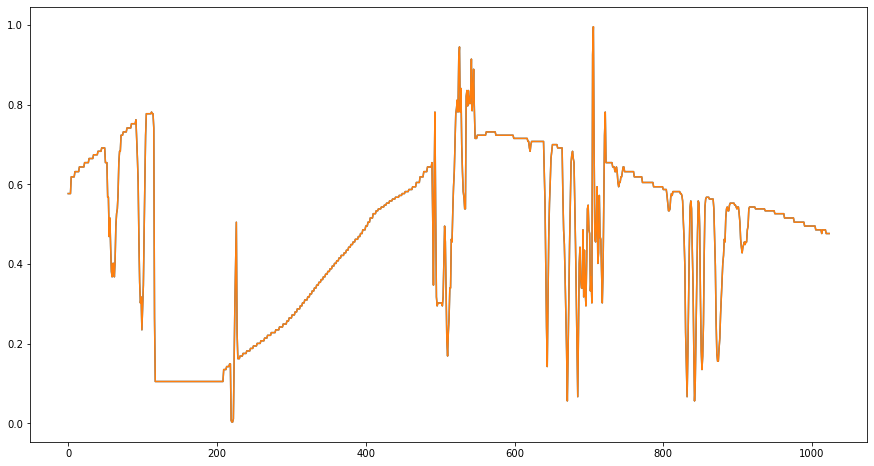

In [55]:
plt.plot(s)
plt.plot(r)

In [56]:
np.std(r-s)

9.51534140331312e-17

### Image subband coding

In [57]:
def decimate_2d(f,h,n):
    out = convolve(f,h)
    out = out[:,n-1::n]
    return out
def interpolate_2d(f,h,n):
    out = np.zeros((f.shape[0],f.shape[1]*n+n-1),dtype=float)
    out[:,n-1::n] = f
    out = convolve(out,h,'valid')
    return out

In [58]:
h0 = np.reshape(h0,(1,-1))
h1 = np.reshape(h1,(1,-1))

In [59]:
L = decimate_2d(I,h0,2)
H = decimate_2d(I,h1,2)

In [60]:
LL = decimate_2d(L.T,h0,2).T
LH = decimate_2d(L.T,h1,2).T
HL = decimate_2d(H.T,h0,2).T
HH = decimate_2d(H.T,h1,2).T

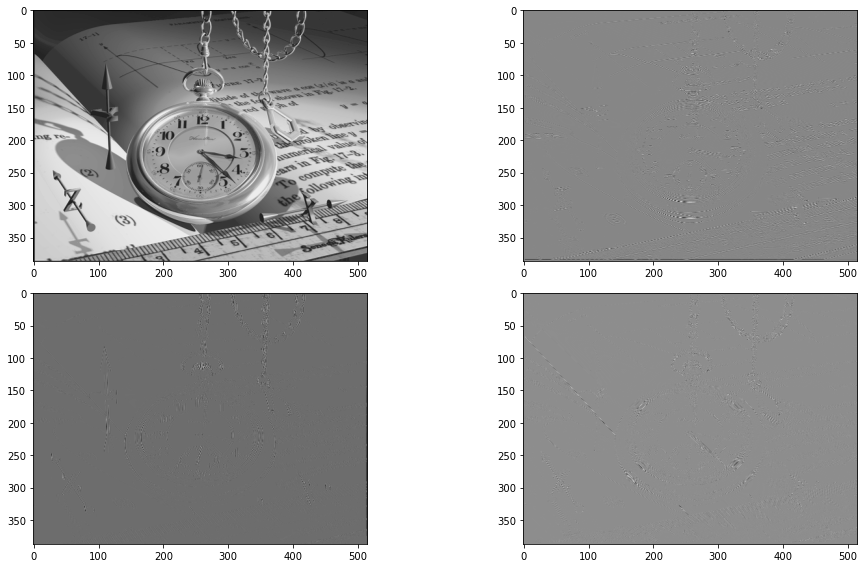

In [61]:
f, ax = plt.subplots(2,2)
ax[0,0].imshow(LL)
ax[0,1].imshow(LH)
ax[1,0].imshow(HL)
ax[1,1].imshow(HH)
plt.tight_layout()

In [62]:
g0 = np.reshape(g0,(1,8))
g1 = np.reshape(g1,(1,8))

In [63]:
RLL = interpolate_2d(LL,g0,2)
RLL = interpolate_2d(RLL.T,g0,2).T

In [64]:
RLH = interpolate_2d(LH,g0,2)
RLH = interpolate_2d(RLH.T,g1,2).T

In [65]:
RHL = interpolate_2d(HL,g1,2)
RHL = interpolate_2d(RHL.T,g0,2).T

In [66]:
RHH = interpolate_2d(HH,g1,2)
RHH = interpolate_2d(RHH.T,g1,2).T

In [67]:
R = RLL + RLH + RHL + RHH

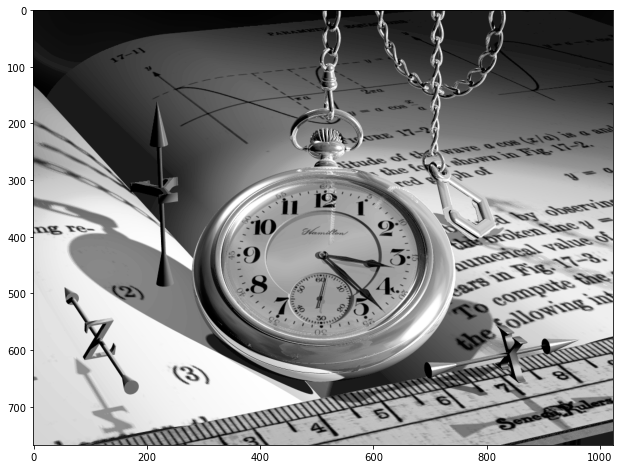

In [68]:
plt.imshow(R)

In [69]:
np.std(I-R)

3.651324386116851e-16